<a href="https://www.kaggle.com/code/afifaf20/courserasupervisedweek2lab3?scriptVersionId=197907146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Goals
In this lab you will:
- Utilize  the multiple variables routines developed in the previous lab
- run Gradient Descent on a data set with multiple features
- explore the impact of the *learning rate alpha* on gradient descent
- improve performance of gradient descent by *feature scaling* using z-score normalization

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from lab_utils_multi import  load_house_data, run_gradient_descent 
from lab_utils_multi import  norm_plot, plt_equal_scale, plot_cost_i_w
from lab_utils_common import dlc
np.set_printoptions(precision=2)
plt.style.use('./deeplearning.mplstyle')

ModuleNotFoundError: No module named 'lab_utils_multi'

## Notation

|General <br />  Notation  | Description| Python (if applicable) |
|: ------------|: ------------------------------------------------------------||
| $a$ | scalar, non bold                                                      ||
| $\mathbf{a}$ | vector, bold                                                 ||
| $\mathbf{A}$ | matrix, bold capital                                         ||
| **Regression** |         |    |     |
|  $\mathbf{X}$ | training example maxtrix                  | `X_train` |   
|  $\mathbf{y}$  | training example  targets                | `y_train` 
|  $\mathbf{x}^{(i)}$, $y^{(i)}$ | $i_{th}$Training Example | `X[i]`, `y[i]`|
| m | number of training examples | `m`|
| n | number of features in each example | `n`|
|  $\mathbf{w}$  |  parameter: weight,                       | `w`    |
|  $b$           |  parameter: bias                                           | `b`    |     
| $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ | The result of the model evaluation at  $\mathbf{x}^{(i)}$ parameterized by $\mathbf{w},b$: $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)}+b$  | `f_wb` | 
|$\frac{\partial J(\mathbf{w},b)}{\partial w_j}$| the gradient or partial derivative of cost with respect to a parameter $w_j$ |`dj_dw[j]`| 
|$\frac{\partial J(\mathbf{w},b)}{\partial b}$| the gradient or partial derivative of cost with respect to a parameter $b$| `dj_db`|

#  Problem Statement

As in the previous labs, you will use the motivating example of housing price prediction. The training data set contains many examples with 4 features (size, bedrooms, floors and age) shown in the table below. Note, in this lab, the Size feature is in sqft while earlier labs utilized 1000 sqft.  This data set is larger than the previous lab.

We would like to build a linear regression model using these values so we can then predict the price for other houses - say, a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old. 

##  Dataset: 
| Size (sqft) | Number of Bedrooms  | Number of floors | Age of  Home | Price (1000s dollars)  |   
| ----------------| ------------------- |----------------- |--------------|----------------------- |  
| 952             | 2                   | 1                | 65           | 271.5                  |  
| 1244            | 3                   | 2                | 64           | 232                    |  
| 1947            | 3                   | 2                | 17           | 509.8                  |  
| ...             | ...                 | ...              | ...          | ...                    |


In [18]:
X_train,y_train=load_house_data()
X_feature =['size(sqft)','bedrooms','floors','age']

NameError: name 'load_house_data' is not defined

Let's view the dataset and its features by plotting each feature versus price.

NameError: name 'X_train' is not defined

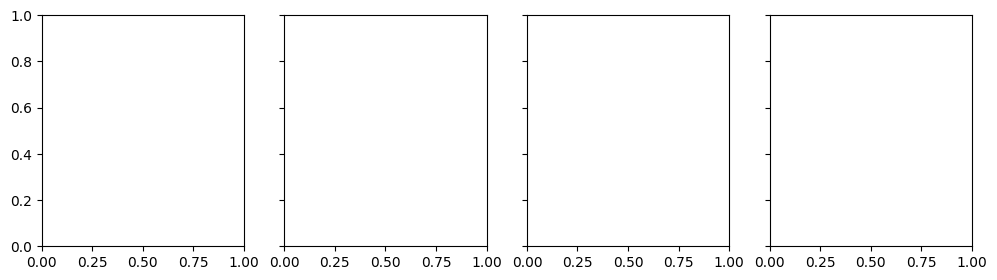

In [19]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

Plotting each feature vs. the target, price, provides some indication of which features have the strongest influence on price. Above, increasing size also increases price. Bedrooms and floors don't seem to have a strong impact on price. Newer houses have higher prices than older houses.

<a name="toc_15456_5"></a>
## Gradient Descent With Multiple Variables
Here are the equations you developed in the last lab on gradient descent for multiple variables.:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j = 0..n-1}\newline
&b\ \ := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


## Feature Scaling 
<figure>
    <img src="./images/C1_W2_Lab06_featurescalingheader.PNG" style="width:1200px;" >
</figure>
The lectures described the importance of rescaling the dataset so the features have a similar range.
If you are interested in the details of why this is the case, click on the 'details' header below. If not, the section below will walk through an implementation of how to do feature scaling.

+-<details>
<summary>
    <font size='3', color='darkgreen'><b>Details</b></font>
</summary>

Let's look again at the situation with $\alpha$ = 9e-7. This is pretty close to the maximum value we can set $\alpha$  to without diverging. This is a short run showing the first few iterations:

<figure>
    <img src="./images/C1_W2_Lab06_ShortRun.PNG" style="width:1200px;" >
</figure>

Above, while cost is being decreased, its clear that $w_0$ is making more rapid progress than the other parameters due to its much larger gradient.

The graphic below shows the result of a very long run with $\alpha$ = 9e-7. This takes several hours.

<figure>
    <img src="./images/C1_W2_Lab06_LongRun.PNG" style="width:1200px;" >
</figure>
    
Above, you can see cost decreased slowly after its initial reduction. Notice the difference between `w0` and `w1`,`w2`,`w3` as well as  `dj_dw0` and `dj_dw1-3`. `w0` reaches its near final value very quickly and `dj_dw0` has quickly decreased to a small value showing that `w0` is near the final value. The other parameters were reduced much more slowly.

Why is this?  Is there something we can improve? See below:
<figure>
    <center> <img src="./images/C1_W2_Lab06_scale.PNG"   ></center>
</figure>   

The figure above shows why $w$'s are updated unevenly. 
- $\alpha$ is shared by all parameter updates ($w$'s and $b$).
- the common error term is multiplied by the features for the $w$'s. (not $b$).
- the features vary significantly in magnitude making some features update much faster than others. In this case, $w_0$ is multiplied by 'size(sqft)', which is generally > 1000,  while $w_1$ is multiplied by 'number of bedrooms', which is generally 2-4. 
    
The solution is Feature Scaling.


### z-score normalization 
After z-score normalization, all features will have a mean of 0 and a standard deviation of 1.

To implement z-score normalization, adjust your input values as shown in this formula:
$$x^{(i)}_j = \dfrac{x^{(i)}_j - \mu_j}{\sigma_j} \tag{4}$$ 
where $j$ selects a feature or a column in the $\mathbf{X}$ matrix. $µ_j$ is the mean of all the values for feature (j) and $\sigma_j$ is the standard deviation of feature (j).
$$
\begin{align}
\mu_j &= \frac{1}{m} \sum_{i=0}^{m-1} x^{(i)}_j \tag{5}\\
\sigma^2_j &= \frac{1}{m} \sum_{i=0}^{m-1} (x^{(i)}_j - \mu_j)^2  \tag{6}
\end{align}
$$

>**Implementation Note:** When normalizing the features, it is important
to store the values used for normalization - the mean value and the standard deviation used for the computations. After learning the parameters
from the model, we often want to predict the prices of houses we have not
seen before. Given a new x value (living room area and number of bed-
rooms), we must first normalize x using the mean and standard deviation
that we had previously computed from the training set.

**Implementation**

In [20]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column
    
    Args:
      X (ndarray (m,n))     : input data, m examples, n features
      
    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma      

    return (X_norm, mu, sigma)
 
#check our work
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

In [21]:
mu     = np.mean(X_train,axis=0)   
sigma  = np.std(X_train,axis=0) 
X_mean = (X_train - mu)
X_norm = (X_train - mu)/sigma      

fig,ax=plt.subplots(1, 3, figsize=(12, 3))
ax[0].scatter(X_train[:,0], X_train[:,3])
ax[0].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[0].set_title("unnormalized")
ax[0].axis('equal')

ax[1].scatter(X_mean[:,0], X_mean[:,3])
ax[1].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[1].set_title(r"X - $\mu$")
ax[1].axis('equal')

ax[2].scatter(X_norm[:,0], X_norm[:,3])
ax[2].set_xlabel(X_features[0]); ax[0].set_ylabel(X_features[3]);
ax[2].set_title(r"Z-score normalized")
ax[2].axis('equal')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("distribution of features before, during, after normalization")
plt.show()

NameError: name 'X_train' is not defined

The plot above shows the relationship between two of the training set parameters, "age" and "size(sqft)". *These are plotted with equal scale*. 
- Left: Unnormalized: The range of values or the variance of the 'size(sqft)' feature is much larger than that of age
- Middle: The first step removes the mean or average value from each feature. This leaves features that are centered around zero. It's difficult to see the difference for the 'age' feature, but 'size(sqft)' is clearly around zero.
- Right: The second step divides by the standard deviation. This leaves both features centered at zero with a similar scale.

In [22]:
# normalize the original features
X_norm, X_mu, X_sigma = zscore_normalize_features(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Peak to Peak range by column in Raw        X:{np.ptp(X_train,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(X_norm,axis=0)}")

NameError: name 'X_train' is not defined

NameError: name 'norm_plot' is not defined

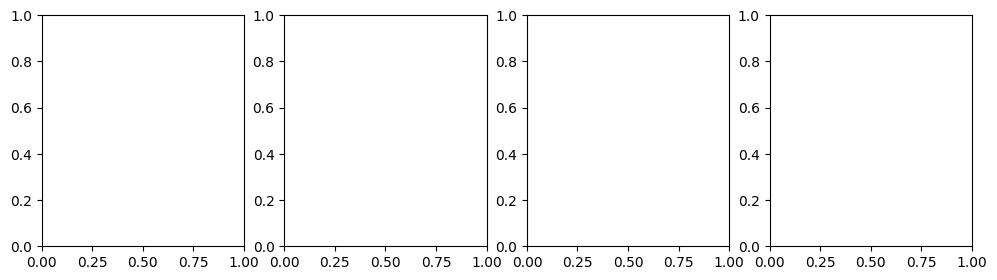

In [23]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3))
for i in range(len(ax)):
    norm_plot(ax[i],X_train[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count");
fig.suptitle("distribution of features before normalization")
plt.show()
fig,ax=plt.subplots(1,4,figsize=(12,3))
for i in range(len(ax)):
    norm_plot(ax[i],X_norm[:,i],)
    ax[i].set_xlabel(X_features[i])
ax[0].set_ylabel("count"); 
fig.suptitle("distribution of features after normalization")

plt.show()

In [24]:
w_norm, b_norm, hist = run_gradient_descent(X_norm, y_train, 1000, 1.0e-1, )

NameError: name 'run_gradient_descent' is not defined

In [25]:
#predict target using normalized features
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train[:,i],yp,color=dlc["dlorange"], label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

NameError: name 'X_norm' is not defined

The results look good. A few points to note:
- with multiple features, we can no longer have a single plot showing results versus features.
- when generating the plot, the normalized features were used. Any predictions using the parameters learned from a normalized training set must also be normalized.

**Prediction**
The point of generating our model is to use it to predict housing prices that are not in the data set. Let's predict the price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old. Recall, that you must normalize the data with the mean and standard deviation derived when the training data was normalized. 

In [26]:
# First, normalize out example.
x_house = np.array([1200, 3, 1, 40])
x_house_norm = (x_house - X_mu) / X_sigma
print(x_house_norm)
x_house_predict = np.dot(x_house_norm, w_norm) + b_norm
print(f" predicted price of a house with 1200 sqft, 3 bedrooms, 1 floor, 40 years old = ${x_house_predict*1000:0.0f}")

NameError: name 'X_mu' is not defined

**Cost Contours**  
<img align="left" src="./images/C1_W2_Lab06_contours.PNG"   style="width:240px;" >Another way to view feature scaling is in terms of the cost contours. When feature scales do not match, the plot of cost versus parameters in a contour plot is asymmetric. 

In the plot below, the scale of the parameters is matched. The left plot is the cost contour plot of w[0], the square feet versus w[1], the number of bedrooms before normalizing the features. The plot is so asymmetric, the curves completing the contours are not visible. In contrast, when the features are normalized, the cost contour is much more symmetric. The result is that updates to parameters during gradient descent can make equal progress for each parameter. 
